# Testing LPP MEG data's validity


## Purpose
The purpose of this notebook is to investigate the correct epoching and trigger time matching for the MEG recordings of the LPP paradigm.

## Methodology

- For each subject, get the 9 epochs corresponding to the first trigger (start of audio).
- Average the MEG channels to see if there's an evoked response to the first audio stimuli

## Results
Currently still investigating the difference in terms of events count.

## Suggested next steps
Isolate the different events to understand the differences in numbers


pip install python-levenshtein# Setup

## Library import
We import all the required Python libraries

In [6]:
# Imports

import mne
import mne_bids
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, scale
from Levenshtein import editops
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib
from joblib import Parallel, delayed
matplotlib.use("Agg")
mne.set_log_level(False)
import time
import os

%matplotlib inline

## Parameter definition


In [8]:
!pwd

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/trigger_testing


In [15]:
"""
Here, we use two datasets, both BIDS formatted

RAW: the raw files organised under the BIDS format
PROC: the processed files that have undergone a Maxwell Filter (Elektra MEG data)

# RAW = "~/workspace_LPP/data/MEG/LPP/LPP_bids"
# PROC = "~/workspace_LPP/data/MEG/LPP/final_all"

"""
class PATHS:
    path_file = Path("./data_path.txt")
    if not path_file.exists():
        data = Path(input("data_path?"))
        assert data.exists()
        with open(path_file, "w") as f:
            f.write(str(data) + "\n")
    with open(path_file, "r") as f:
        data = Path(f.readlines()[0].strip("\n"))
        print(f'File opened: {data}')
        if str(data).__contains__('final'):
            print("Processed data (Maxwell filtered) used")
        if str(data).__contains__('BIDS'):
            print("Raw data (no filtering) used")
    print(data)
    assert data.exists()




File opened: /home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all
Processed data (Maxwell filtered) used
/home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all


In [12]:
from Levenshtein import editops


def match_list(A, B, on_replace="delete"):
    """Match two lists of different sizes and return corresponding indice
    Parameters
    ----------
    A: list | array, shape (n,)
        The values of the first list
    B: list | array: shape (m, )
        The values of the second list
    Returns
    -------
    A_idx : array
        The indices of the A list that match those of the B
    B_idx : array
        The indices of the B list that match those of the A
    """

    if not isinstance(A, str):
        unique = np.unique(np.r_[A, B])
        label_encoder = dict((k, v) for v, k in enumerate(unique))

        def int_to_unicode(array: np.ndarray) -> str:
            return "".join([str(chr(label_encoder[ii])) for ii in array])

        A = int_to_unicode(A)
        B = int_to_unicode(B)

    changes = editops(A, B)
    B_sel = np.arange(len(B)).astype(float)
    A_sel = np.arange(len(A)).astype(float)
    for type_, val_a, val_b in changes:
        if type_ == "insert":
            B_sel[val_b] = np.nan
        elif type_ == "delete":
            A_sel[val_a] = np.nan
        elif on_replace == "delete":
            # print('delete replace')
            A_sel[val_a] = np.nan
            B_sel[val_b] = np.nan
        elif on_replace == "keep":
            # print('keep replace')
            pass
        else:
            raise NotImplementedError
    B_sel = B_sel[np.where(~np.isnan(B_sel))]
    A_sel = A_sel[np.where(~np.isnan(A_sel))]
    assert len(B_sel) == len(A_sel)
    return A_sel.astype(int), B_sel.astype(int)

In [17]:
# Uncomment if on DELL
#PATHS.data = Path("/home/co/workspace_LPP/data/MEG/LPP/LPP_bids")


# Data import
We retrieve all the required data for the analysis.

In [16]:
subjects = pd.read_csv(str(PATHS.data) + "/participants.tsv", sep="\t")
subjects = subjects.participant_id.apply(lambda x: x.split("-")[1]).values
subjects = np.delete(subjects,subjects.shape[0]-1)
print(subjects)

['180517' '181017' '190506' '190513' '190611' '190621' '190715' '190717'
 '220628']


Rename the fif files that have been preprocessed to the BIDS standart (*_raw.fif to *_meg.fif)

In [6]:
# Done already for the current batch of filtered data by the MNE BIDS Pipeline
"""
for subject in subjects:
    subj_path = os.path.join(bids,'sub-'+subject,'ses-01/meg')
    for filename in os.listdir(subj_path):
        infilename = os.path.join(subj_path,filename)
        if not os.path.isfile(infilename): continue
        oldbase = os.path.splitext(filename)
        newname = infilename.replace('raw.fif', 'meg.fif')
        output = os.rename(infilename, newname)
        
"""

"\nfor subject in subjects:\n    subj_path = os.path.join(bids,'sub-'+subject,'ses-01/meg')\n    for filename in os.listdir(subj_path):\n        infilename = os.path.join(subj_path,filename)\n        if not os.path.isfile(infilename): continue\n        oldbase = os.path.splitext(filename)\n        newname = infilename.replace('raw.fif', 'meg.fif')\n        output = os.rename(infilename, newname)\n        \n"

Add the needed files (events, headposition & co) to the newly generated post-processing folders (done manually; faster than doing a regex)

# Data processing


## Trying to use the first trigger to see the evoked response

### For one subject: testing the STIM channels & triggers

In [9]:
def epoch_data(subject, run_id):

    # define path
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session='01',
        task='rest',
        datatype="meg",
        root=PATHS.data,
        run=run_id,
        #processing = 'sss'
    )

    raw = mne_bids.read_raw_bids(bids_path)
    raw.pick_types(meg='mag', stim=True)
    raw.load_data()
    raw = raw.filter(.5, 20)

    event_file = PATHS.data/f'sub-{bids_path.subject}'
    event_file = event_file / f'ses-{bids_path.session}'
    event_file = event_file / 'meg'
    event_file = str(event_file / f'sub-{bids_path.subject}')
    event_file += f'_ses-{bids_path.session}'
    event_file += f'_task-{bids_path.task}'
    event_file += f'_run-{bids_path.run}_events.tsv'
    Path(event_file).exists()
    
    # read events
    meta = pd.read_csv(event_file, sep='\t')
    events = mne.find_events(raw, stim_channel='STI101')
    
    # match events and metadata
    word_events = events[events[:, 2]==128]
    meg_delta = np.round(np.diff(word_events[:, 0]/raw.info['sfreq']))
    meta_delta = np.round(np.diff(meta.onset.values))
    i, j = match_list(meg_delta, meta_delta)
    assert len(i) > 1000
    events = events[i]
    meta = meta.iloc[j].reset_index()

    epochs = mne.Epochs(raw, events, metadata=meta, tmin=-.3, tmax=.8, decim=10)
    return epochs

In [10]:
for subject in subjects[[-1]]:
    epochs = []
    for run_id in range(1, 10):
        print('.', end='')
        epo = epoch_data(subject, '%.2i' % run_id)
        epochs.append(epo)
    break

.

<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.

<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.

<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.

<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.

<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.

<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.

<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.

<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


.

<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-9-b9c1102df6f3>:14: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


In [11]:
for epo in epochs:
    epo.info['dev_head_t'] = epochs[0].info['dev_head_t']

epochs = mne.concatenate_epochs(epochs)

<ipython-input-11-e461d7e7a336>:4: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


In [14]:
data = epochs.get_data()

In [15]:
n_words, n_chans, n_times = data.shape 
vec = data.transpose(0, 2, 1).reshape(-1, n_chans)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
idx = np.arange(len(vec))
np.random.shuffle(idx)
vec = scaler.fit(vec[idx[:20_000]]).transform(vec)
vec = np.clip(vec, -15, 15)
epochs._data[:,:,:] = scaler.inverse_transform(vec).reshape(n_words, n_times, n_chans).transpose(0, 2, 1)

In [16]:
evo = epochs.average();

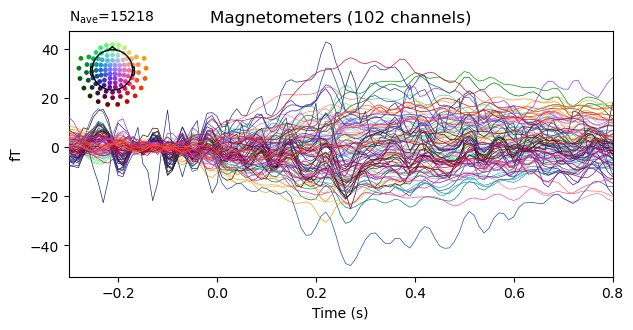

In [18]:
evo.plot(spatial_colors=True);

In [1]:
evo

NameError: name 'evo' is not defined

In [33]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, scale
from wordfreq import zipf_frequency

def decod(X, y):
    assert len(X) == len(y)
    
    # define data
    model = make_pipeline(StandardScaler(), Ridge())
    cv = KFold(5, shuffle=True, random_state=0)

    # fit predict
    n, n_chans, n_times = X.shape
    R = np.zeros(n_times)
    for t in range(n_times):
        print('.', end='')
        y_pred = cross_val_predict(model, X[:, :, t], y, cv=cv)
        R[t] = correlate(y, y_pred)
    return R

# Function to correlate 

def correlate(X, Y):
    if X.ndim == 1:
        X = X[:, None]
    if Y.ndim == 1:
        Y = Y[:, None]
    X = X - X.mean(0)
    Y = Y - Y.mean(0)

    SX2 = (X**2).sum(0) ** 0.5
    SY2 = (Y**2).sum(0) ** 0.5
    SXY = (X * Y).sum(0)
    return SXY / (SX2 * SY2)


In [21]:
#pip install wordfreq
from wordfreq import zipf_frequency

In [25]:
epochs.metadata['kind'] = epochs.metadata.trial_type.apply(lambda s: eval(s)['kind'])
epochs.metadata['word'] = epochs.metadata.trial_type.apply(lambda s: eval(s)['word'])

In [26]:
X = epochs.get_data()

y = epochs.metadata.word.apply(lambda w: zipf_frequency(w, 'fr'))

In [34]:
R = decod(X, y)

.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


.

<ipython-input-33-70ebea93da71>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


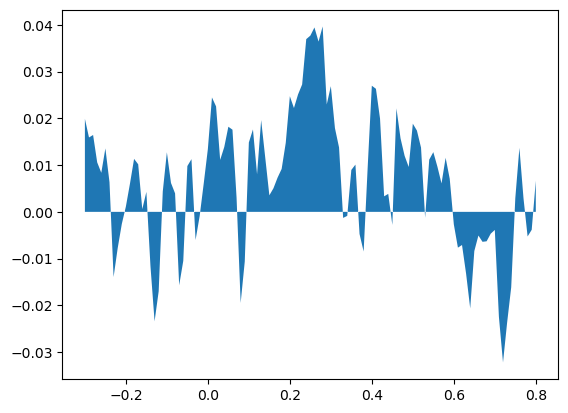

In [37]:
plt.fill_between(epochs.times, R)